<a href="https://colab.research.google.com/github/sadbinsiddique/cvpr-face-detection/blob/main/face_recognition_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50, MobileNetV2

In [15]:
# Check if TensorFlow is using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("✅ GPU is being used")
    except RuntimeError as e:
        print("❌ Error setting GPU memory growth:", e)
else:
    print("❌ No GPU found, using CPU instead")

✅ GPU is being used


In [16]:
# ==== CONFIGURATION ====
dataset_dir = "/content/drive/MyDrive/images (1)"
image_size = 237
batch_size = 16
epochs = 30

# ==== DATA AUGMENTATION ====
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    dataset_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    dataset_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 1200 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [17]:
# ==== CLASS COUNT & CONFIG ====
num_classes = train_data.num_classes

if num_classes == 2:
    final_activation = 'sigmoid'
    loss_fn = 'binary_crossentropy'
    output_units = 1
else:
    final_activation = 'softmax'
    loss_fn = 'categorical_crossentropy'
    output_units = num_classes

In [18]:
# ==== SAVE CLASS INDICES ====
with open("class_indices.json", "w") as f:
    json.dump(train_data.class_indices, f)
print("✅ Class indices saved to class_indices.json")

✅ Class indices saved to class_indices.json


In [22]:
# ==== BASE MODELS ====
input_tensor = Input(shape=(image_size, image_size, 3))

effnet = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)
resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)
mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor)

for layer in effnet.layers: layer.trainable = False
for layer in resnet.layers: layer.trainable = False
for layer in mobilenet.layers: layer.trainable = False

x1 = GlobalAveragePooling2D()(effnet.output)
x2 = GlobalAveragePooling2D()(resnet.output)
x3 = GlobalAveragePooling2D()(mobilenet.output)

merged = Concatenate()([x1, x2, x3])
x = Dense(512, activation='relu')(merged)
x = Dropout(0.5)(x)
output = Dense(output_units, activation=final_activation)(x)

model = Model(inputs=input_tensor, outputs=output)

<ipython-input-22-9a2321021535>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor)


In [23]:
# ==== COMPILE ====
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [25]:
# ==== SUMMARY & CALLBACKS ====
model.summary()

log_dir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    TensorBoard(log_dir=log_dir),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_multimodel.h5", monitor="val_accuracy", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 237, 237,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 237, 237,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 237, 237,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 237, 237,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 239, 239,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 119, 119,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 119, 119,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 119, 119,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 119, 119,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 119, 119,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 119, 119,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 119, 119,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 119, 119,  │        512 │ block1a_se_excit

 Total params: 32,256,614 (123.05 MB)

 Trainable params: 2,361,347 (9.01 MB)

 Non-trainable params: 29,895,267 (114.04 MB)

In [26]:
# ==== TRAIN ====
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.6873 - loss: 1.1249
Epoch 1: val_accuracy improved from -inf to 0.97333, saving model to best_multimodel.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 95s 723ms/step - accuracy: 0.6889 - loss: 1.1180 - val_accuracy: 0.9733 - val_loss: 0.1009 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9290 - loss: 0.1743
Epoch 2: val_accuracy improved from 0.97333 to 0.99000, saving model to best_multimodel.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 376ms/step - accuracy: 0.9291 - loss: 0.1742 - val_accuracy: 0.9900 - val_loss: 0.0524 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9633 - loss: 0.1090
Epoch 3: val_accuracy did not improve from 0.99000
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 359ms/step - accuracy: 0.9633 - loss: 0.1089 - val_accuracy: 0.9867 - val_loss: 0.0503 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9521 - loss: 0.1245
Epoch 4: val_accuracy improved from 0.99000 to 0.99333, saving model to best_multimodel.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 373ms/step - accuracy: 0.9520 - loss: 0.1246 - val_accuracy: 0.9933 - val_loss: 0.0393 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9538 - loss: 0.0903
Epoch 5: val_accuracy improved from 0.99333 to 0.99667, saving model to best_multimodel.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 441ms/step - accuracy: 0.9539 - loss: 0.0904 - val_accuracy: 0.9967 - val_loss: 0.0320 - learning_rate: 0.0010
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9641 - loss: 0.0914
Epoch 6: val_accuracy did not improve from 0.99667
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 351ms/step - accuracy: 0.9641 - loss: 0.0914 - val_accuracy: 0.9767 - val_loss: 0.0780 - learning_rate: 0.0010
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9731 - loss: 0.0788
Epoch 7: val_accuracy did not improve from 0.99667

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 356ms/step - accuracy: 0.9731 - loss: 0.0787 - val_accuracy: 0.9933 - val_loss: 0.0387 - learning_rate: 0.0010
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9830 - loss: 0.0480
Epoch 8: val_accuracy did not improve from 0.99667
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 358ms/step - accuracy: 0.9829 - loss: 0.0481 - val_accu

In [31]:
# ==== SAVE ====
model.save('best_model.h5')
print("✅ Final model saved!")

✅ Final model saved!


In [32]:
# ==== EVALUATION ====
val_steps = val_data.samples // val_data.batch_size + 1
val_data.reset()
preds = model.predict(val_data, steps=val_steps)

if num_classes == 2:
    y_pred = (preds > 0.5).astype(int).flatten()
else:
    y_pred = np.argmax(preds, axis=1)

y_true = val_data.classes
labels = list(train_data.class_indices.keys())

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=labels))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_true, y_pred))

19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step

=== Classification Report ===
              precision    recall  f1-score   support

         jon       0.98      1.00      0.99       100
        siam       1.00      1.00      1.00       100
        tony       1.00      0.98      0.99       100

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

=== Confusion Matrix ===
[[100   0   0]
 [  0 100   0]
 [  2   0  98]]


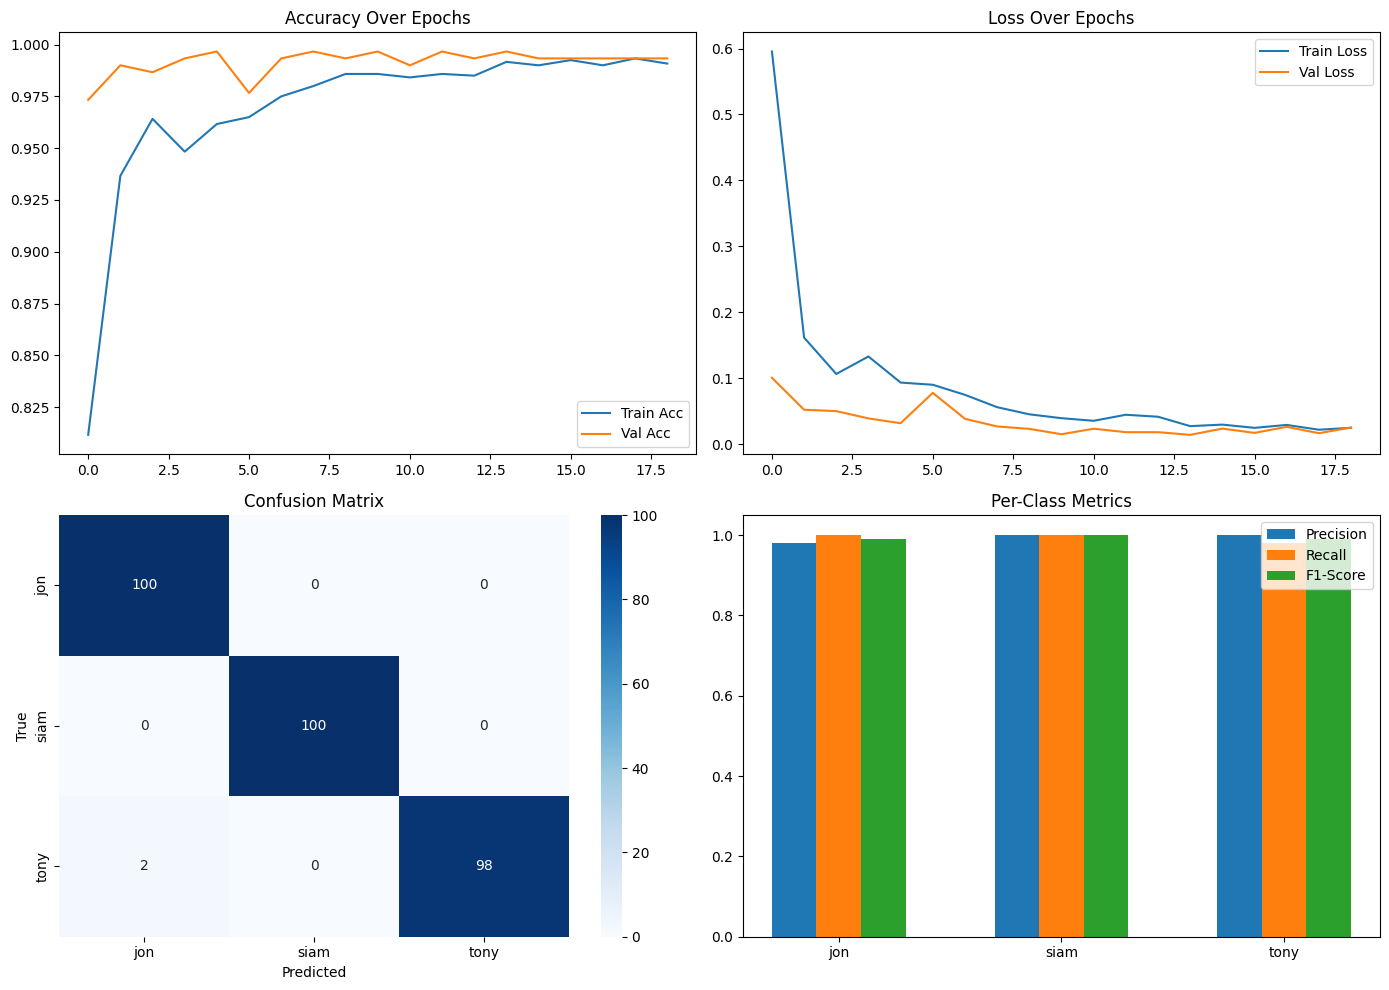

In [33]:
# ==== DASHBOARD ====
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(2, 2, 3)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2, 2, 4)
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
scores = {m: [report[l][m] for l in labels] for m in ['precision', 'recall', 'f1-score']}

x = np.arange(len(labels))
w = 0.2
plt.bar(x - w, scores['precision'], w, label='Precision')
plt.bar(x, scores['recall'], w, label='Recall')
plt.bar(x + w, scores['f1-score'], w, label='F1-Score')
plt.xticks(ticks=x, labels=labels)
plt.ylim(0, 1.05)
plt.title('Per-Class Metrics')
plt.legend()
plt.tight_layout()

plt.show()
